# Прогнозирование оттока клиентов банка

## Описание проекта
«Бета-Банк» теряет клиентов. Каждый месяц. Немного, но заметно.\
Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.\
Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.\
Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком

## Задачи проекта:
- построить модель с предельно большим значением F1-меры
- довести F1-меру min до 0.59
- проверить F1-меру на тестовой выборке
- дополнительно измерить AUC-ROC и сравнить её значение с F1-мерой

## 1. Открываем файл с данными и изучаем общую информацию

### 1.1. Импорт необходимых для работы библиотек, метрик и утилит

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
import winsound
from tqdm import tqdm

# импорт моделей
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# метрики
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# утилиты 
from sklearn.utils import shuffle

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

### 1.2. Загрузка исходных данных

In [2]:
# загрузим исходные данные
data = pd.read_csv('C:\\Users\\Mikhail\\Яндекс_Практикум\\data_set\\Churn.csv')

In [3]:
# общая информация о таблице
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


### 1.3. Описание данных

**Признаки**

- **RowNumber** — индекс строки в данных
- **CustomerId** — уникальный идентификатор клиента
- **Surname** — фамилия
- **CreditScore** — кредитный рейтинг
- **Geography** — страна проживания
- **Gender** — пол
- **Age** — возраст
- **Tenure** — сколько лет человек является клиентом банка
- **Balance** — баланс на счёте
- **NumOfProducts** — количество продуктов банка, используемых клиентом
- **HasCrCard** — наличие кредитной карты
- **IsActiveMember** — активность клиента
- **EstimatedSalary** — предполагаемая зарплата

**Целевой признак**
- **Exited** — факт ухода клиента

In [4]:
# определим количество пропусков
data.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

### Выводы

1. Данные в ячейках соответствуют типу и описанию.
2. Названия столбцов приведем к нижнему регистру, а слова разделим нижним подчеркиванием.
3. Обнаружены пропуски в столбце Tenure (сколько лет человек является клиентом банка), что можно сделать:
-  хороший вариант - выяснить у Заказчика причину пропусков и восстановить данные, но такой возможности нет;
-  удалять строки с пропусками нежелательно, так как это почти 10% исходных данных;
-  могу предположить, что пропуски связаны с тем, что клиент обслуживается в банке меньше года и тогда можно будет заполнить их нулем (то есть неполный год)
4. Столбец **RowNumber** (индекс строки в данных) для исследования не потребуется и его можно удалить уже на этом этапе.
5. Столбцы **CustomerId** (уникальный идентификатор клиента) и **Surname** (фамилия) - это уникальные значения клиентов и скорее всего не повлияют на обучение модели. Предполагаю, что фамилия и id не влияют на продолжительность сотрудничества с банком, вероятно, эти столбцы тоже можно будет удалить. 
6. Столбцы **Geography** (страна проживания) и **Age** (возраст) относятся к категориальным признакам и потребуют кодирования.
7. Сохраним исходные данные в **data**, а данные для обучения будем готовить в **df**.

In [5]:
# исходные данные оставим в data, готовить данные для обучения будем в df
df = data.copy()

In [6]:
# удалим первый столбец RowNumber(индекс строки в данных)
df.drop(columns=data.columns [0], axis=1, inplace=True)

In [7]:
# приведем регистр в названиях столбцов к нижнему значению
df.columns = df.columns.str.lower()

In [8]:
# переименование столбцов
df = df.rename(columns={'customerid':'customer_id',
          'creditscore':'credit_score',
          'numofproducts':'num_of_products',
          'hascrcard':'has_cr_card',
          'isactivemember':'is_active_member',
          'estimatedsalary':'estimated_salary'}
)

In [9]:
# изучим уникальные названия в столбце с 'tenure'
df.tenure.value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: tenure, dtype: int64

В данных есть значения равные "0", значит заполнять пропуски "0" не будем.\
Примем решение о заполнении на следующем этапе.

In [10]:
# подсчёт явных дубликатов
df.duplicated().sum()

0

In [11]:
# удалим столбцы с уникальными данными клиентов, которые не повлияют на обучение модели
df = df.drop(['customer_id', 'surname'], axis=1)

In [12]:
df.columns

Index(['credit_score', 'geography', 'gender', 'age', 'tenure', 'balance',
       'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited'],
      dtype='object')

In [13]:
# проверим изменения
df.head(10)

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [14]:
# оценим корреляцию данных
df.corr()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
credit_score,1.000000,-0.003965,-0.000062,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
age,-0.003965,1.000000,-0.013134,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
tenure,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761
balance,0.006268,0.028308,-0.007911,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
num_of_products,0.012238,-0.030680,0.011979,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
has_cr_card,-0.005458,-0.011721,0.027232,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
is_active_member,0.025651,0.085472,-0.032178,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
estimated_salary,-0.001384,-0.007201,0.010520,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097
exited,-0.027094,0.285323,-0.016761,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000


Сильных корреляционных взаимосвязей между данными не обнаружено.

## 2. Построим гистограммы для числовых столбцов таблицы

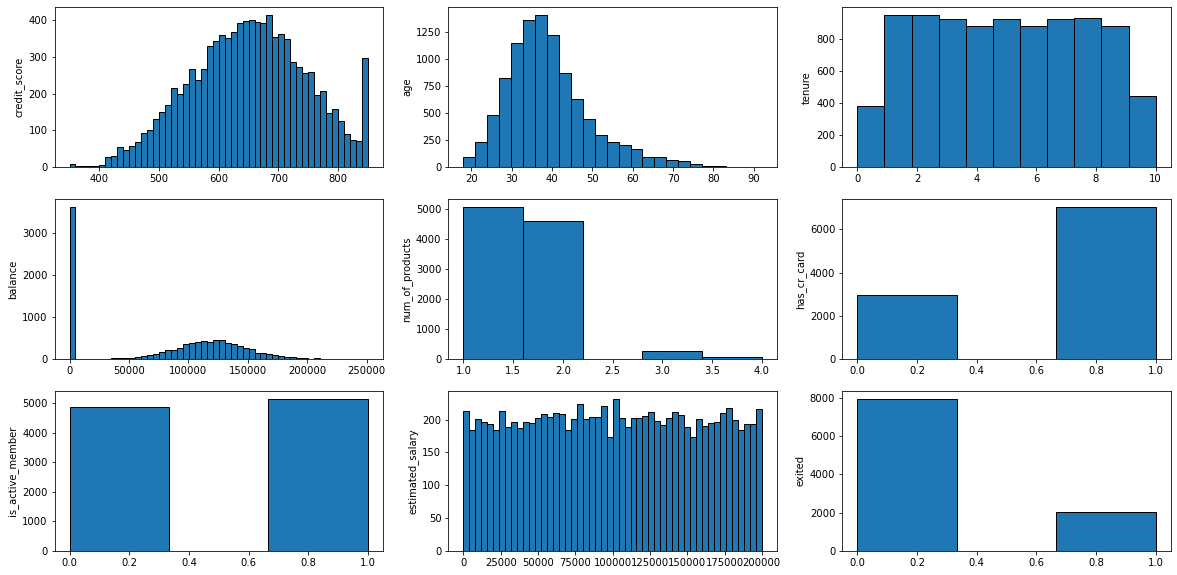

In [15]:
# отобразим числовые данные на графиках 

fig, axis = plt.subplots(3,3, figsize=(20,10))

df['credit_score'].plot.hist(ax=axis[0,0], edgecolor='black', linewidth=1, bins=50).set(ylabel='credit_score');
df['age'].plot.hist(ax=axis[0,1], edgecolor='black', linewidth=1, bins=25).set(ylabel='age');
df['tenure'].plot.hist(ax=axis[0,2], edgecolor='black', linewidth=1, bins=11).set(ylabel='tenure');
df['balance'].plot.hist(ax=axis[1,0], edgecolor='black', linewidth=1, bins=50).set(ylabel='balance');
df['num_of_products'].plot.hist(ax=axis[1,1], edgecolor='black', linewidth=1, bins=5).set(ylabel='num_of_products');
df['has_cr_card'].plot.hist(ax=axis[1,2], edgecolor='black', linewidth=1, bins=3).set(ylabel='has_cr_card');
df['is_active_member'].plot.hist(ax=axis[2,0], edgecolor='black', linewidth=1, bins=3).set(ylabel='is_active_member');
df['estimated_salary'].plot.hist(ax=axis[2,1], edgecolor='black', linewidth=1, bins=50).set(ylabel='estimated_salary');
df['exited'].plot.hist(ax=axis[2,2], edgecolor='black', linewidth=1, bins=3).set(ylabel='exited');

### Выводы

1. Наблюдаются выбросы значений в столбцах: 'credit_score', 'balance';
2. Хвосты в столбцах: 'age', num_of_products;
3. Дисбаланс данных в столбцах: 'num_of_products', 'has_cr_card', 'exited'

На следующих шагах проведем обработку данных, чтобы избавиться от выбросов и привести их к нормальному распределению.

## 3. Исследуем числовые признаки

* 3.1. **credit_score** - кредитный рейтинг
* 3.2. **age** - возраст
* 3.3. **balance** - баланс
* 3.4. **estimated_salary** - предполагаемая зарплата
* 3.5. **tenur** - сколько лет является клиентом банка

In [16]:
# исследуем выбивающиеся значения в столбцах
(
    df[['credit_score', 'age', 'tenure', 'balance', 'estimated_salary']]
    .apply (['count', 'min', 'mean', 'median', 'max'])
    .style.format("{:,.2f}")
)

,credit_score,age,tenure,balance,estimated_salary
count,"10,000.00","10,000.00","9,091.00","10,000.00","10,000.00"
min,350.00,18.00,0.00,0.00,11.58
mean,650.53,38.92,5.00,"76,485.89","100,090.24"
median,652.00,37.00,5.00,"97,198.54","100,193.91"
max,850.00,92.00,10.00,"250,898.09","199,992.48"


### 3.1. Столбец "credit_score"

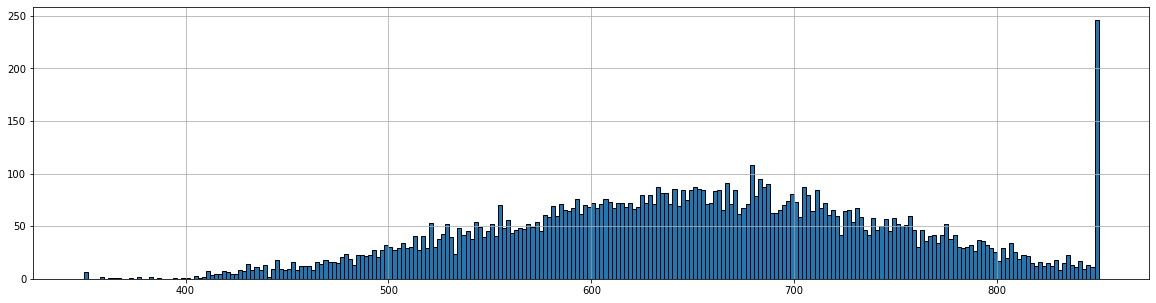

In [17]:
# построим гистограмму
df.credit_score.hist(bins = 250, edgecolor='black', linewidth=1, figsize = (20,5));

In [18]:
# исследуем выбивающиеся значения в колонке "кредитный ретинг"
df.credit_score.describe().to_frame().style.format("{:,.2f}")

,credit_score
count,"10,000.00"
mean,650.53
std,96.65
min,350.00
25%,584.00
50%,652.00
75%,718.00
max,850.00


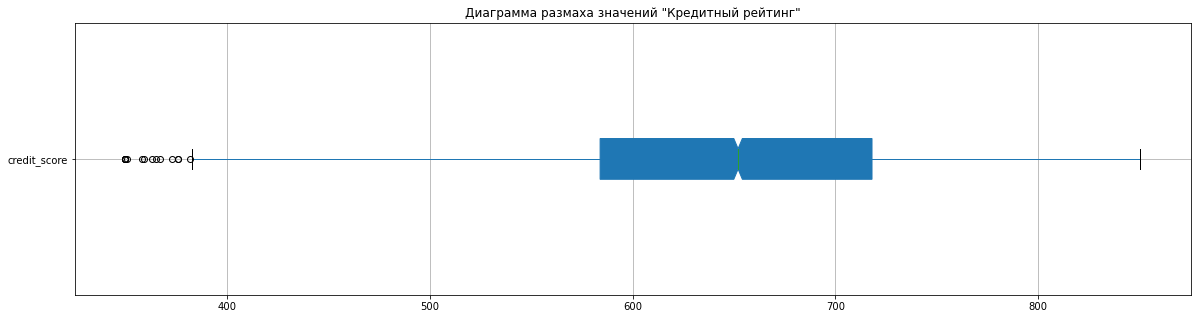

In [19]:
# построим боксплот для столбца "credit_score
fig, ax = plt.subplots(figsize = (20,5))
ax = df[['credit_score']].boxplot(vert=False, ax=ax, patch_artist=True, notch=True)
ax.set_title('Диаграмма размаха значений "Кредитный рейтинг"');

In [20]:
# посчитаем квантили и выведем верхнюю и нижнюю границы боксплота
Q1 = df.credit_score.quantile(0.25)
Q3 = df.credit_score.quantile(0.75)
IQR = Q3 - Q1
upper = Q3 + 1.5 * IQR
lower = Q1 - 1.5 * IQR 

print('Верхняя граница:', upper)
print('Нижняя граница:', lower)

Верхняя граница: 919.0
Нижняя граница: 383.0


In [21]:
# оценим количество строк с кредитным рейтингом менее 383
df[['credit_score']].query('383 > credit_score').count()

credit_score    15
dtype: int64

In [22]:
# строки можно удалить, это всего 15 строк 
df = df.query('383 < credit_score')

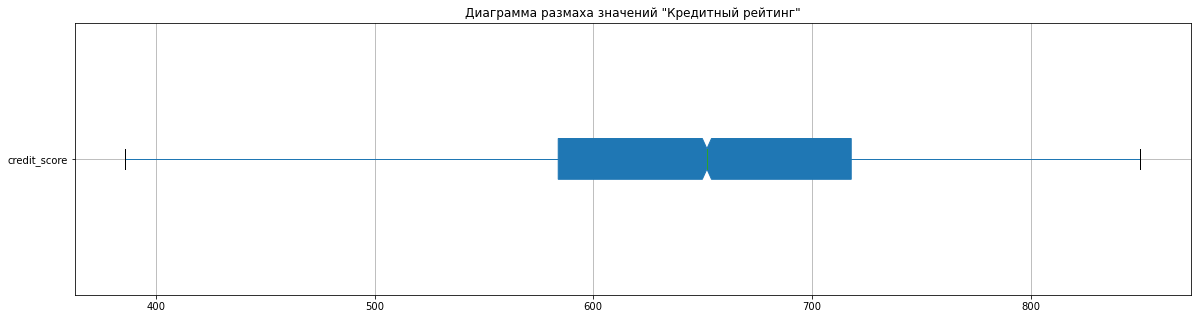

In [23]:
# построим боксплот по новым данным 
fig, ax = plt.subplots(figsize = (20,5))
ax = df[['credit_score']].boxplot(vert=False, ax=ax, patch_artist=True, notch=True)
ax.set_title('Диаграмма размаха значений "Кредитный рейтинг"');

* Боксплот более сбалансированный

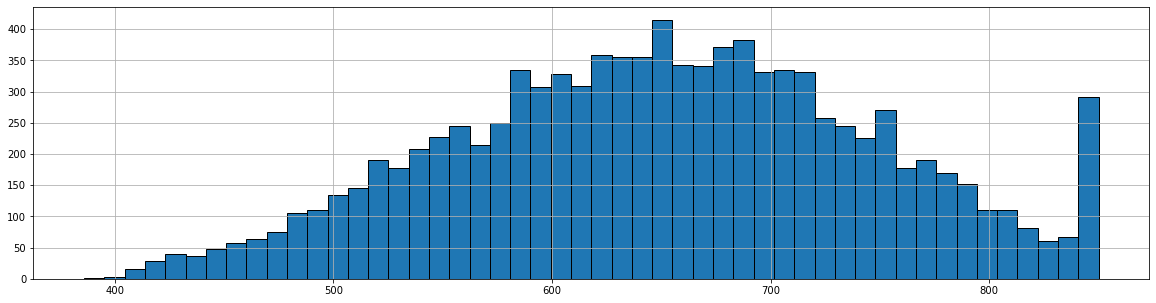

In [24]:
df.credit_score.hist(bins = 50, figsize = (20,5), edgecolor='black', linewidth=1);

* Распределение данных близко к нормальному

### 3.2. Столбец "age"

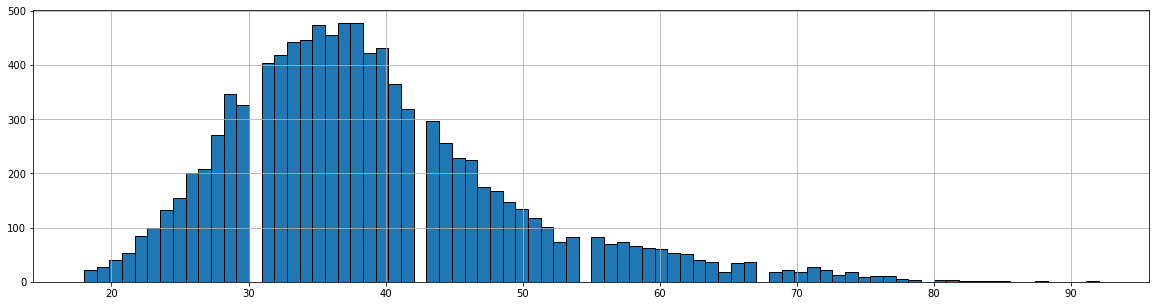

In [25]:
# построим гистограмму для столбца возраст
df.age.hist(bins = 80, edgecolor='black', linewidth=1, figsize = (20,5));

* "Хвост" после 60

In [26]:
# исследуем выбивающиеся значения в колонке "возраст"
df.age.describe().to_frame().style.format("{:,.2f}")

,age
count,"9,984.00"
mean,38.91
std,10.49
min,18.00
25%,32.00
50%,37.00
75%,44.00
max,92.00


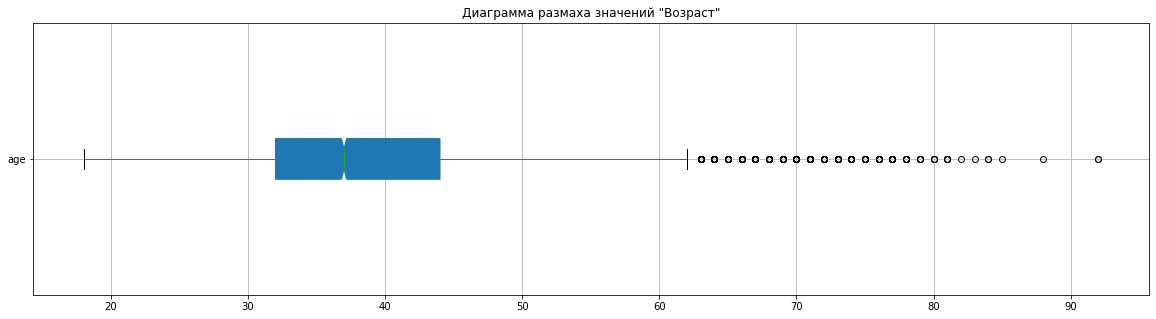

In [27]:
# построим боксплот для столбца "age"
fig, ax = plt.subplots(figsize = (20,5))
ax = df[['age']].boxplot(vert=False, ax=ax, patch_artist=True, notch=True)
ax.set_title('Диаграмма размаха значений "Возраст"');

* Боксплот смещен влево
* Определяются выбросы

In [28]:
# посчитаем квантили и выведем верхнюю и нижнюю границы боксплота
Q1 = df.age.quantile(0.25)
Q3 = df.age.quantile(0.75)
IQR = Q3 - Q1
upper = Q3 + 1.5 * IQR
lower = Q1 - 1.5 * IQR 

print('Верхняя граница:', upper)
print('Нижняя граница:', lower)

Верхняя граница: 62.0
Нижняя граница: 14.0


In [29]:
# оценим количество строк с возрастом более 62
df[['age']].query('age > 62').count()

age    359
dtype: int64

In [30]:
# удалим строки с выбросами
df = df.query('age <= 62')

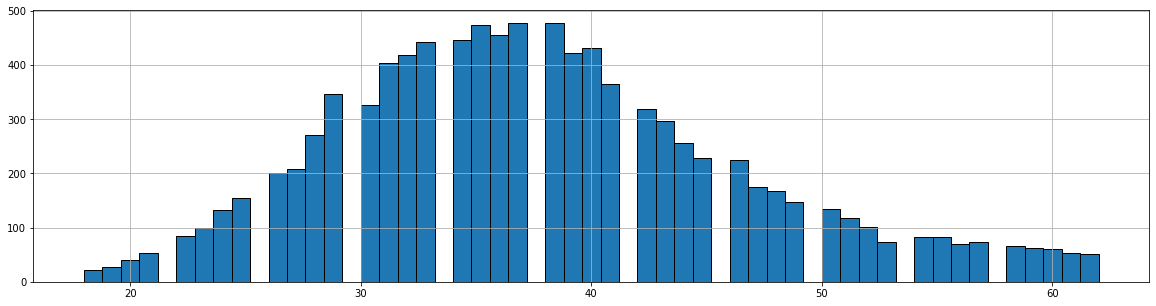

In [31]:
# построим гистограмму
df.age.hist(bins = 55, edgecolor='black', linewidth=1, figsize = (20,5));

* Распределение данных близко к нормальному
* Выбросов нет

### 3.3. Столбец "balance"

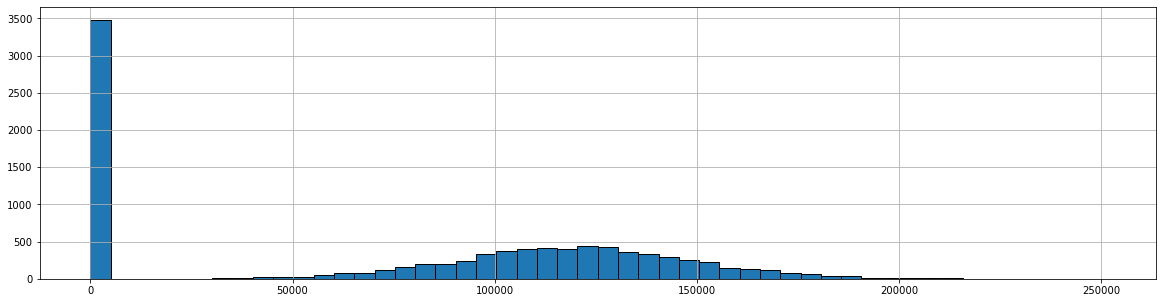

In [32]:
# построим гистограмму
df.balance.hist(bins = 50, edgecolor='black', linewidth=1, figsize = (20,5));

In [33]:
# исследуем выбивающиеся значения в колонке "баланс"
df.balance.describe().to_frame().style.format("{:,.2f}")

,balance
count,"9,625.00"
mean,"76,543.81"
std,"62,402.20"
min,0.00
25%,0.00
50%,"97,286.16"
75%,"127,649.64"
max,"250,898.09"


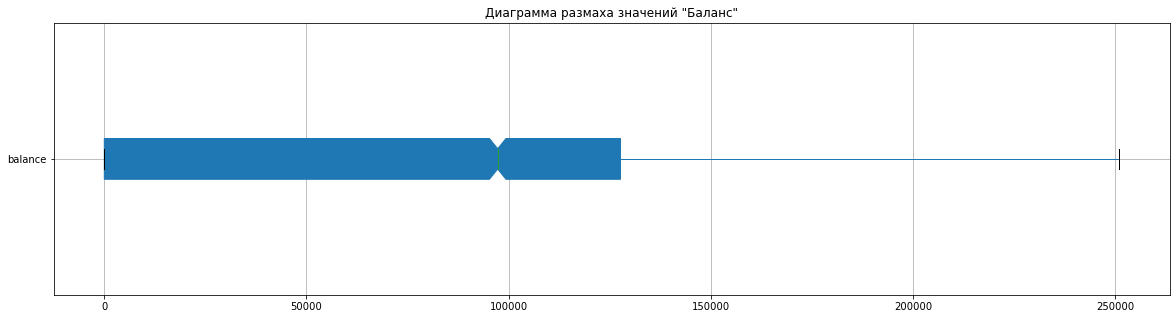

In [34]:
# построим боксплот для столбца "balance"
fig, ax = plt.subplots(figsize = (20,5))
ax = df[['balance']].boxplot(vert=False, ax=ax, patch_artist=True, notch=True)
ax.set_title('Диаграмма размаха значений "Баланс"');

In [35]:
# посчитаем квантили и выведем верхнюю и нижнюю границы боксплота
Q1 = df.balance.quantile(0.25)
Q3 = df.balance.quantile(0.75)
IQR = Q3 - Q1
upper = Q3 + 1.5 * IQR
lower = Q1 - 1.5 * IQR 

print('Верхняя граница:', upper)
print('Нижняя граница:', lower)

Верхняя граница: 319124.1
Нижняя граница: -191474.46


* В столбце выбросы не обнаружены, но наблюдается смещение влево
* Много значений равных нулю, более трети всех данных
* Оставим без изменений

### 3.4. Столбец "estimated_salary"

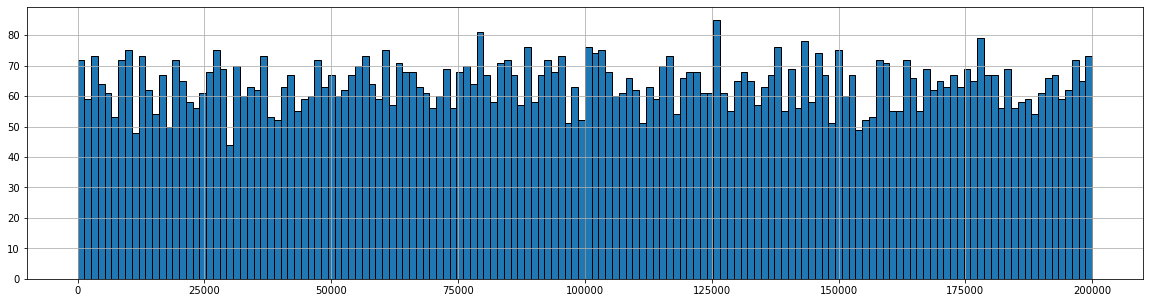

In [36]:
# построим гистограмму
df.estimated_salary.hist(bins = 150, edgecolor='black', linewidth=1, figsize = (20,5));

In [37]:
# исследуем выбивающиеся значения в столбца "предполагаемая зарплата"
df.estimated_salary.describe().to_frame().style.format("{:,.2f}")

,estimated_salary
count,"9,625.00"
mean,"100,109.46"
std,"57,523.28"
min,11.58
25%,"51,011.29"
50%,"100,183.05"
75%,"149,418.41"
max,"199,992.48"


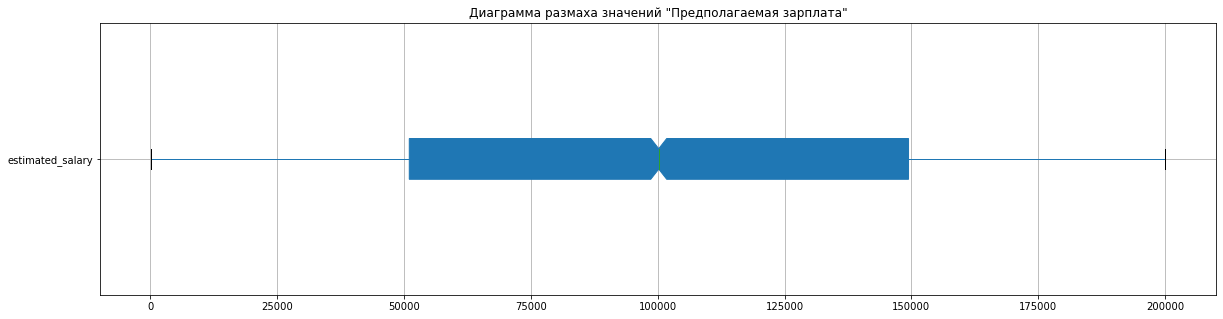

In [38]:
# построим боксплот для столбца "estimated_salary"
fig, ax = plt.subplots(figsize = (20,5))
ax = df[['estimated_salary']].boxplot(vert=False, ax=ax, patch_artist=True, notch=True)
ax.set_title('Диаграмма размаха значений "Предполагаемая зарплата"');

* Боксплот симметричный, выбросов нет
* Данные в обработке не нуждаются

### 3.5. Столбец "tenure"

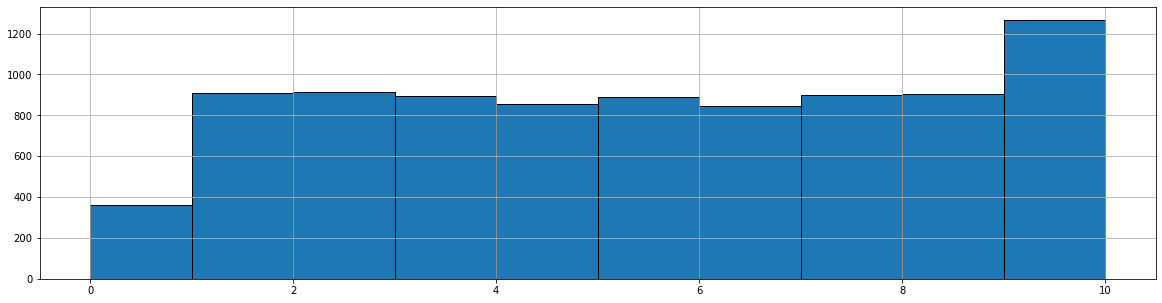

In [39]:
# построим гистограмму
df.tenure.hist(bins = 10, edgecolor='black', linewidth=1, figsize = (20,5));

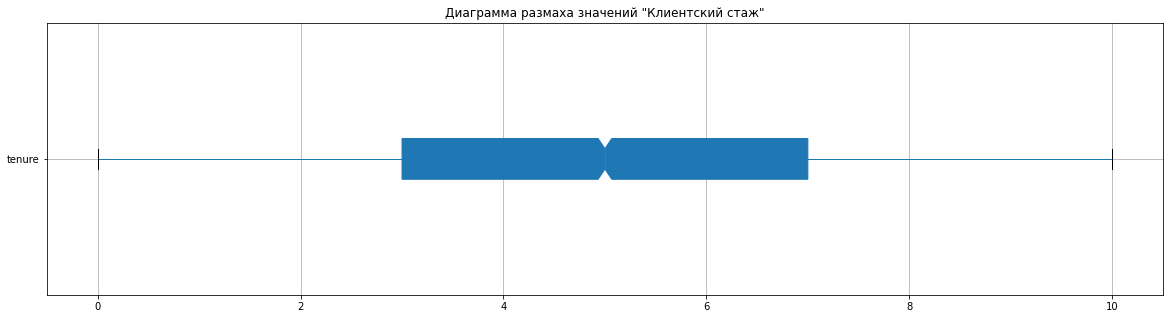

In [40]:
# построим боксплот для столбца "tenure"
fig, ax = plt.subplots(figsize = (20,5))
ax = df[['tenure']].boxplot(vert=False, ax=ax, patch_artist=True, notch=True)
ax.set_title('Диаграмма размаха значений "Клиентский стаж"');

In [41]:
# исследуем выбивающиеся значения в столбца "стаж клиента"
df.tenure.describe().to_frame().style.format("{:,.2f}")

,tenure
count,"8,741.00"
mean,5.00
std,2.89
min,0.00
25%,3.00
50%,5.00
75%,7.00
max,10.00


* Так как разброс данных небольшой, заполним пропуски медианой - сохраним целочисленное значение признака
* Выбросы не обнаружены, наблюдается смещение влево

In [42]:
# заполним пропуски в столбце "tenure' медианой 
df.tenure = df.tenure.fillna(df.tenure.median())

In [43]:
df.tenure.value_counts()

5.0     1775
2.0      914
1.0      908
8.0      904
7.0      899
3.0      894
4.0      855
6.0      846
9.0      839
10.0     428
0.0      363
Name: tenure, dtype: int64

In [44]:
# проверим остались ли пропуски
df.isna().sum()

credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

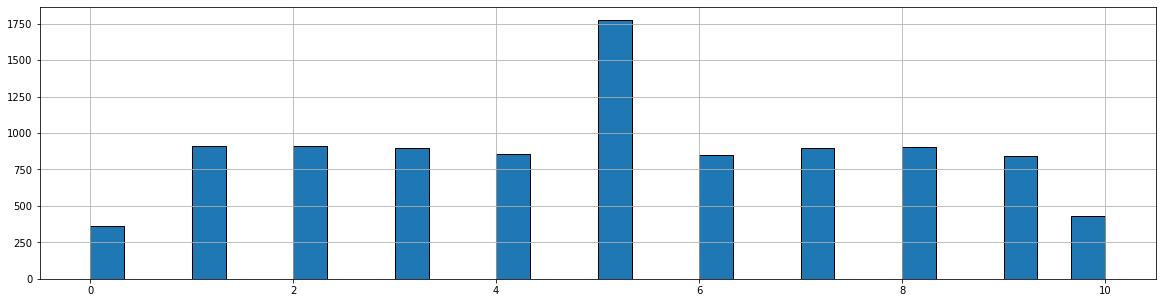

In [45]:
# построим гистограмму
df.tenure.hist(bins = 30, edgecolor='black', linewidth=1, figsize = (20,5));

In [46]:
print('Исходные данные:' , len(data))
print('Очищенные данные:', len(df))
print(f'Удалили {((len(data) - len(df))/(len(data))):.2%} от исходных данных')

Исходные данные: 10000
Очищенные данные: 9625
Удалили 3.75% от исходных данных


### Выводы

1. Числовые данные очищены от выбросов.
2. Удалены столбцы с избыточными признаками.
3. Пропускив столбце **tenure** заполнили медианой.
4. Удалили 3.75% объектов от исходных данных.

## 4. Исследуем категориальные признаки

* **geography** — страна проживания
* **gender** — пол
* **num_of_products** - количество продуктов
* **has_cr_card** - наличие кредитной карты
* **is_active_member** - активность


### 4.1. Оценим сбалансированность в категориальных признаках

In [47]:
# страна проживания
df.geography.value_counts().to_frame()

,geography
France,4826
Germany,2421
Spain,2378


In [48]:
# пол
df.gender.value_counts().to_frame()

,gender
Male,5258
Female,4367


In [49]:
# количество продуктов
df.num_of_products.value_counts().to_frame()

,num_of_products
1,4881
2,4435
3,251
4,58


In [50]:
# наличие кредитной карты
df.has_cr_card.value_counts().to_frame()

,has_cr_card
1,6786
0,2839


In [51]:
# активность 
df.is_active_member.value_counts().to_frame()

,is_active_member
1,4847
0,4778


## Выводы

Наблюдаем дисбаланс в категориальных признаках:
1. **geography** - страна проживания
2. **num_of_products** - количество продуктов
3. **has_cr_card** - наличие кредитной карты

## 5. Подготовим данные для модели "Логистическая регрессия"

### 5.1. Преобразуем категориальные данные прямым кодированием

In [52]:
# преобразуем категориальные данные в таблице техникой OHE
df_ohe = pd.get_dummies(df, drop_first=True)

In [53]:
# результат прямой кодировки для модели "Логическая регрессия"
df_ohe.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


### 5.2. Разделим выборки и извлечем признаки
* **train** - обучающая выборка (**60%** исходных данных)
* **valid** - валидационная выборка (**20%** исходных данных)
* **test** - тестовая выборка (**20%** исходных данных)

In [54]:
features = df_ohe.drop('exited', axis=1)                      # признаки
target = df_ohe['exited']                                     # выделим целевой признак

# отделим тренировочную выборку 60%
# целевой признак не сбалансирован, поэтому используем параметр "stratify"
features_train_lr, features_rest_lr, target_train_lr, target_rest_lr = train_test_split(features, target, test_size=0.4, random_state=12345, stratify=target)

# разделим валидоционную и тестовую выборки
features_test_lr, features_valid_lr, target_test_lr, target_valid_lr = train_test_split(features_rest_lr, target_rest_lr, train_size=0.5, random_state=12345, stratify=target_rest_lr)
                                                    

In [55]:
print ('Обучающая выборка', '\n', 'Признаки:',features_train_lr.shape, '\n', 'Целевой признак:', target_train_lr.shape, '\n', sep='')

Обучающая выборка
Признаки:(5775, 11)
Целевой признак:(5775,)



In [56]:
print ('Валидационная выборка', '\n', 'Признаки:',features_valid_lr.shape, '\n', 'Целевой признак:', target_valid_lr.shape, '\n', sep='')

Валидационная выборка
Признаки:(1925, 11)
Целевой признак:(1925,)



In [57]:
print ('Тестовая выборка', '\n', 'Признаки:',features_test_lr.shape, '\n', 'Целевой признак:', target_test_lr.shape, '\n', sep='')

Тестовая выборка
Признаки:(1925, 11)
Целевой признак:(1925,)



### 5.3. Масштабируем числовые признаки

In [58]:
# сохраним в numeric список всех численных признаков
numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']

# создадим объект структуры StandardScaler и настроим его на обучающих данных
scaler = StandardScaler()
scaler.fit(features_train_lr[numeric])

# изменённые наборы сохраним в переменных
features_train_lr[numeric] = scaler.transform(features_train_lr[numeric])
features_valid_lr[numeric] = scaler.transform(features_valid_lr[numeric])
features_test_lr[numeric] = scaler.transform(features_test_lr[numeric])

# добавим, чтобы предупреждение предупреждение SettingWithCopy не появлялось
pd.options.mode.chained_assignment = None

features_train_lr.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
4184,-0.539456,2.440667,1.086701,0.663719,0.838720,0,0,-0.708341,1,0,1
8491,0.010453,0.492851,-1.090849,1.063392,0.838720,1,0,-0.996682,0,1,1
6528,-0.477202,-1.225809,-0.002074,0.393520,-0.899209,0,0,-1.229018,0,1,1
8106,-0.622461,1.524048,-0.002074,0.122991,0.838720,1,1,1.565415,0,1,0
3453,-0.321567,0.263697,-0.002074,0.429608,0.838720,0,0,0.696049,1,0,1


## 6. Исследуем модель "Логистическая регрессия"

In [59]:
# создадим и обучим модель Логистическая регрессия
model_lr = LogisticRegression(solver='liblinear', random_state = 12345)
model_lr.fit(features_train_lr, target_train_lr) 

# получим предсказание на валидационной выборке
predicted_valid_lr = model_lr.predict(features_valid_lr)

# посчитаем значение accuracy на валидационной выборке и выведем его
print('Accuracy модели LogisticRegression: ', accuracy_score(target_valid_lr, predicted_valid_lr), '\n', sep='')

# посчитаем значение F1-score на валидационной выборке и выведем его
print('F1-score модели LogisticRegression: ', f1_score(target_valid_lr, predicted_valid_lr), '\n', sep='')

# найдем значения вероятностей классов для валидационной выборки
probabilities_valid = model_lr.predict_proba(features_valid_lr)

# выберем вероятности положительного класса ("1")
probabilities_one_valid = probabilities_valid[:, 1]

# посчитаем значение AUC-ROC на валидационной выборке и выведем его
auc_roc = roc_auc_score(target_valid_lr, probabilities_one_valid)

print('AUC-ROC модели LogisticRegression: ', auc_roc, '\n', sep='')

Accuracy модели LogisticRegression: 0.8171428571428572

F1-score модели LogisticRegression: 0.38461538461538464

AUC-ROC модели LogisticRegression: 0.7796098436161097



### 6.1. Проверим модель "Логистическая регрессия" на адекватность

In [60]:
# проверка модели на адекватность
# создадим константную модель: любому объекту она прогнозирует класс «0»
target_pred_constant = pd.Series(0, index=target_valid_lr.index)

# посчитаем значение accuracy
print('Accuracy константной модели: ', accuracy_score(target_valid_lr, target_pred_constant), '\n', sep='')

# посчитаем значение F1-score 
print('F1-score константной модели: ', f1_score(target_pred_constant, predicted_valid_lr), '\n', sep='')

Accuracy константной модели: 0.7979220779220779

F1-score константной модели: 0.0



### 6.2. Проверим, как часто в целевом признаке встречается класс «1» или «0»

    exited
0  0.79761
1  0.20239


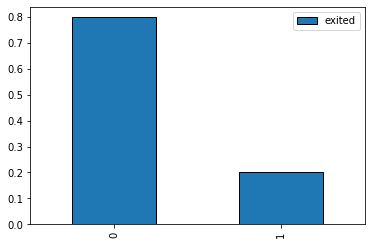

In [61]:
# посчитаем количество уникальных значений в целевом признаке
class_frequency = df['exited'].value_counts(normalize= True).to_frame()
print(class_frequency)
class_frequency.plot(kind='bar', edgecolor='black', linewidth=1);

In [9]:
df['exited'].mean()

0.2037

### Выводы

* Целевой признак не сбалансирован
* Accuracy модели LogisticRegression практически совпадает с количеством отрицательных значений целевого признака
* Accuracy модели LogisticRegression и константной модели практически одинаковы
* F1-score константной модели равна "0"

**Mодель не проходит проверку на адекватность.\
Целевой признак необходимо сбалансировать.**

### 6.3. Изменим порог классификации

In [62]:
# игнорируем предупреждение
warnings.filterwarnings('ignore')

# найдем значения вероятностей классов для валидационной выборки
probabilities_valid = model_lr.predict_proba(features_valid_lr)
probabilities_one_valid = probabilities_valid[:, 1]

best_threshold = 0
best_result = 0

for threshold in np.arange(0, 0.95, 0.05):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid_lr, predicted_valid)
    recall = recall_score(target_valid_lr, predicted_valid)
    result = f1_score(target_valid_lr, predicted_valid)

    if result > best_result:
        best_threshold = threshold
        best_result = result
    
    print('Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f} | F1-мера = {:.3f}'.format(
             threshold, precision, recall, result))
print()
print('F1-мера лучшей модели = ', f'{best_result:.3f}','\n', sep='')
print('Порог классификации =', best_threshold)

Порог = 0.00 | Точность = 0.202, Полнота = 1.000 | F1-мера = 0.336
Порог = 0.05 | Точность = 0.233, Полнота = 0.967 | F1-мера = 0.375
Порог = 0.10 | Точность = 0.285, Полнота = 0.892 | F1-мера = 0.432
Порог = 0.15 | Точность = 0.334, Полнота = 0.784 | F1-мера = 0.468
Порог = 0.20 | Точность = 0.393, Полнота = 0.715 | F1-мера = 0.507
Порог = 0.25 | Точность = 0.436, Полнота = 0.617 | F1-мера = 0.511
Порог = 0.30 | Точность = 0.475, Полнота = 0.545 | F1-мера = 0.508
Порог = 0.35 | Точность = 0.509, Полнота = 0.483 | F1-мера = 0.496
Порог = 0.40 | Точность = 0.547, Полнота = 0.406 | F1-мера = 0.466
Порог = 0.45 | Точность = 0.578, Полнота = 0.342 | F1-мера = 0.430
Порог = 0.50 | Точность = 0.601, Полнота = 0.283 | F1-мера = 0.385
Порог = 0.55 | Точность = 0.684, Полнота = 0.239 | F1-мера = 0.354
Порог = 0.60 | Точность = 0.743, Полнота = 0.193 | F1-мера = 0.306
Порог = 0.65 | Точность = 0.767, Полнота = 0.144 | F1-мера = 0.242
Порог = 0.70 | Точность = 0.826, Полнота = 0.098 | F1-мера = 0

### 6.4. Изменим гиперпараметры class_weight и max_iter

In [63]:
# обучим модель "Логистическая регрессия"  с гиперпараметром class_weight='balanced'

model_lr = LogisticRegression(solver='liblinear', random_state = 12345, class_weight='balanced', max_iter=1000)
model_lr.fit(features_train_lr, target_train_lr) 

predicted_valid_lr = model_lr.predict(features_valid_lr)

# найдем значения вероятностей классов для валидационной выборки
probabilities_valid = model_lr.predict_proba(features_valid_lr)

# выберем вероятности положительного класса ("1")
probabilities_one_valid = probabilities_valid[:, 1]

# посчитаем значение AUC-ROC на валидационной выборке и выведем его
auc_roc = roc_auc_score(target_valid_lr, probabilities_one_valid)
print('AUC-ROC модели LogisticRegression: ', auc_roc, '\n', sep='')

# посчитаем значение F1-score на валидационной выборке и выведем его
print('F1-score модели LogisticRegression: ', f1_score(target_valid_lr, predicted_valid_lr), '\n', sep='')

AUC-ROC модели LogisticRegression: 0.7816617127249359

F1-score модели LogisticRegression: 0.49907918968692444



Показатель F1-score всё ещё далек от желаемого.

### 6.5. Применим технику upsampling

In [64]:
# функция для увеличения и перемешивания выборок, функция вернёт признаки и целевой признак после операции upsampling  
def upsample(features, target, repeat):                          # параметры функции: признаки, целевой признак, количество повторений
    features_zeros = features_train_lr[target_train_lr == 0]           # признаки объектов с ответом «0»
    features_ones = features_train_lr[target_train_lr == 1]            # признаки объектов с ответом «1»
    target_zeros = target_train_lr [target_train_lr == 0]              # целевой признак объектов, у которых ответы только «0»
    target_ones = target_train_lr [target_train_lr == 1]               # целевой признак объектов, у которых ответы только «1»
    
    # объединим таблицы с признаками и сохраним результат в переменной features_upsampled
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    
    # то же самое для целевого признака
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    # перемешаем
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled,random_state=12345)

    return features_upsampled, target_upsampled

# вызов функции
features_upsampled, target_upsampled = upsample(features_train_lr, target_train_lr, 4)

# проверим, что получилось
print(features_upsampled.shape)
print(target_upsampled.shape)

(9282, 11)
(9282,)


     exited
1  0.503771
0  0.496229


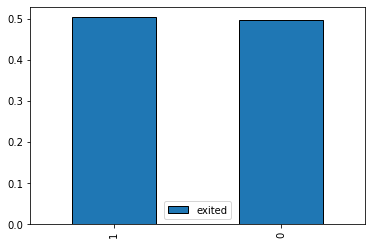

In [65]:
# проверим соотношение уникальных значений в целевом признаке после upsampling
class_frequency = target_upsampled.value_counts(normalize= True).to_frame()
print(class_frequency)
class_frequency.plot(kind='bar', edgecolor='black', linewidth=1);

In [66]:
# обучим модель "Логистическая регрессия" на увеличенных данных

model_lr = LogisticRegression(solver='liblinear', random_state = 12345, max_iter=1000)
model_lr.fit(features_upsampled, target_upsampled) 

predicted_valid_lr = model_lr.predict(features_valid_lr)

# найдем значения вероятностей классов для валидационной выборки
probabilities_valid = model_lr.predict_proba(features_valid_lr)

# выберем вероятности положительного класса ("1")
probabilities_one_valid = probabilities_valid[:, 1]

# посчитаем значение AUC-ROC на валидационной выборке и выведем его
auc_roc = roc_auc_score(target_valid_lr, probabilities_one_valid)

print('AUC-ROC модели LogisticRegression: ', auc_roc, '\n', sep='')

# посчитаем значение F1-score на валидационной выборке и выведем его
print('F1-score модели LogisticRegression: ', f1_score(target_valid_lr, predicted_valid_lr), '\n', sep='')

AUC-ROC модели LogisticRegression: 0.7817102479648672

F1-score модели LogisticRegression: 0.5009174311926605



### 6.6. Применим технику downsampling

In [67]:
# функция для уменьшения и перемешивания
def downsample(features, target, fraction):              # параметры функции: признаки, целевой признак, количество повторений    
    features_zeros = features_train_lr[target_train_lr == 0]           # признаки объектов с ответом «0»
    features_ones = features_train_lr[target_train_lr == 1]            # признаки объектов с ответом «1»
    target_zeros = target_train_lr [target_train_lr == 0]              # целевой признак объектов, у которых ответы только «0»
    target_ones = target_train_lr [target_train_lr == 1]               # целевой признак объектов, у которых ответы только «1»
    
    # объединим таблицы с признаками и сохраним результат в переменной 
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    
    # то же самое для целевого признака
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    # перемешиваем данные
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled,random_state=12345)
    
    return features_downsampled, target_downsampled

# вызов функции
features_downsampled, target_downsampled = downsample(features_train_lr, target_train_lr, 0.25)

# проверим, что получилось
print(features_downsampled.shape)
print(target_downsampled.shape)

(2321, 11)
(2321,)


In [68]:
# проверим соотношение уникальных значений в целевом признаке после downsampling
class_frequency = target_downsampled.value_counts(normalize= True).to_frame()
print(class_frequency)

     exited
1  0.503662
0  0.496338


In [69]:
# обучим модель "Логистическая регрессия" на уменьшенных данных
model_lr = LogisticRegression(solver='liblinear', random_state = 12345, max_iter=1000)
model_lr.fit(features_downsampled, target_downsampled) 

predicted_valid_lr = model_lr.predict(features_valid_lr)

# найдем значения вероятностей классов для валидационной выборки
probabilities_valid = model_lr.predict_proba(features_valid_lr)

# выберем вероятности положительного класса ("1")
probabilities_one_valid = probabilities_valid[:, 1]

# посчитаем значение AUC-ROC на валидационной выборке и выведем его
auc_roc = roc_auc_score(target_valid_lr, probabilities_one_valid)
print('AUC-ROC модели LogisticRegression: ', auc_roc, '\n', sep='')

# посчитаем значение F1-score на валидационной выборке и выведем его
print('F1-score модели LogisticRegression: ', f1_score(target_valid_lr, predicted_valid_lr), '\n', sep='')

AUC-ROC модели LogisticRegression: 0.7817604568337617

F1-score модели LogisticRegression: 0.5013723696248856



### 6.7. Построим PR-кривую для модели "Логистическая регрессия"

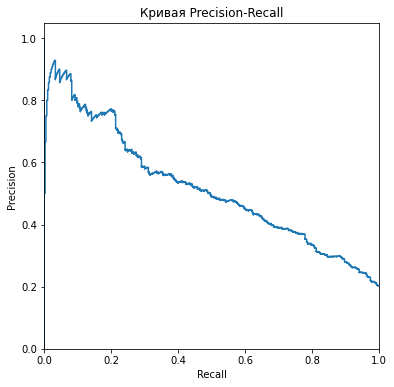

CPU times: total: 375 ms
Wall time: 86.6 ms


In [70]:
%%time
# обучим модель "Логистическая регрессия" на увеличенных данных
model_lr = LogisticRegression(solver='liblinear', random_state = 12345, max_iter=1000)
model_lr.fit(features_upsampled, target_upsampled) 

# найдем значения вероятностей классов для валидационной выборки
probabilities_valid = model_lr.predict_proba(features_valid_lr)

precision, recall, thresholds = precision_recall_curve(target_valid_lr, probabilities_valid[:, 1])

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show()

### 6.8. Построим ROC-кривую для модели "Логистическая регрессия"

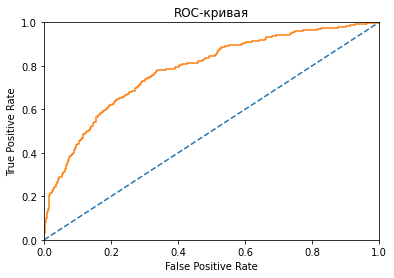

CPU times: total: 312 ms
Wall time: 78.3 ms


In [71]:
%%time
# обучим модель "Логистическая регрессия" на увеличенных данных
model_lr = LogisticRegression(solver='liblinear', random_state = 12345, class_weight='balanced', max_iter=1000)
model_lr.fit(features_upsampled, target_upsampled) 

# найдем значения вероятностей классов для валидационной выборки
probabilities_valid = model_lr.predict_proba(features_valid_lr)

# выберем вероятности положительного класса ("1")
probabilities_one_valid = probabilities_valid[:, 1]

# передаем на вход значения целевого признака и вероятности положительного класса
fpr, tpr, thresholds = roc_curve(target_valid_lr, probabilities_one_valid)

# строим график
plt.figure()

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(fpr, tpr)
# функции plt.xlim() и plt.ylim(), чтобы установить границы осей от 0 до 1
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# подпишем оси "False Positive Rate" и "True Positive Rate"
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# заголовок "ROC-кривая"
plt.title('ROC-кривая')
plt.show()

### 6.9. Рассчитаем AUC-ROC для модели "Логистическая регрессия" 

In [72]:
auc_roc = roc_auc_score(target_valid_lr, probabilities_one_valid)
print('AUC модели LogisticRegression: ', auc_roc)

AUC модели LogisticRegression:  0.7817052270779778


## Выводы

* F1-score лучшей модели LogisticRegression: 0.50, целевой уровень не достигнут
* AUC модели LogisticRegression: 0.78, модель с высокой вероятностью сможет различить положительные и отрицательные значения 

## 7. Подготовим данные для моделей "Решаюшее дерево" и "Случайный лес"

### 7.1. Используем порядковое кодирование

In [73]:
# создаём объект для этой структуры данных
encoder = OrdinalEncoder()

# вызываем метод fit(), чтобы получить список категориальных признаков
encoder.fit(df)

OrdinalEncoder()

In [74]:
# измененные данные преобразуем функцией transform() и сохраним в переменной data_ordinal
df_ordinal = encoder.transform(df)

# оформим данные в структуру DataFrame()
df_ordinal = pd.DataFrame(encoder.transform(df), columns=df.columns)

In [75]:
# результат порядковой кодировки для моделей "Решаюшее дерево" и "Случайный лес"
df_ordinal.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,217.0,0.0,0.0,24.0,2.0,0.0,0.0,1.0,1.0,4879.0,1.0
1,206.0,2.0,0.0,23.0,1.0,715.0,0.0,0.0,1.0,5421.0,0.0
2,100.0,0.0,0.0,24.0,8.0,5579.0,2.0,1.0,0.0,5486.0,1.0
3,297.0,0.0,0.0,21.0,1.0,0.0,1.0,0.0,0.0,4527.0,0.0
4,448.0,2.0,0.0,25.0,2.0,3561.0,0.0,1.0,1.0,3770.0,0.0


### 7.2. Разделим выборки и извлечем признаки
* **train** - обучающая выборка (**60%** исходных данных)
* **valid** - валидационная выборка (**20%** исходных данных)
* **test** - тестовая выборка (**20%** исходных данных)

In [76]:
features = df_ordinal.drop('exited', axis=1)                      # признаки
target = df_ordinal['exited']                                     # выделим целевой признак

# отделим тренировочную выборку 60%
# целевой признак не сбалансирован, поэтому используем параметр "stratify"
features_train_tf, features_rest_tf, target_train_tf, target_rest_tf = train_test_split(features, target, test_size=0.4, random_state=12345, stratify=target)

# разделим валидоционную и тестовую выборки
features_test_tf, features_valid_tf, target_test_tf, target_valid_tf = train_test_split(features_rest_tf, target_rest_tf, train_size=0.5, random_state=12345, stratify=target_rest_tf)
                                                    

In [77]:
print ('Обучающая выборка', '\n', 'Признаки:',features_train_tf.shape, '\n', 'Целевой признак:', target_train_tf.shape, '\n', sep='')

Обучающая выборка
Признаки:(5775, 10)
Целевой признак:(5775,)



In [78]:
print ('Валидационная выборка', '\n', 'Признаки:',features_valid_tf.shape, '\n', 'Целевой признак:', target_valid_tf.shape, '\n', sep='')

Валидационная выборка
Признаки:(1925, 10)
Целевой признак:(1925,)



In [79]:
print ('Тестовая выборка', '\n', 'Признаки:',features_test_tf.shape, '\n', 'Целевой признак:', target_test_tf.shape, '\n', sep='')

Тестовая выборка
Признаки:(1925, 10)
Целевой признак:(1925,)



### 7.4. Масштабируем числовые признаки

In [80]:
# сохраним в numeric список всех численных признаков
numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']

# создадим объект структуры StandardScaler и настроим его на обучающих данных
scaler = StandardScaler()
scaler.fit(features_train_tf[numeric])

# изменённые наборы сохраним в переменных
features_train_tf[numeric] = scaler.transform(features_train_tf[numeric])
features_valid_tf[numeric] = scaler.transform(features_valid_tf[numeric])
features_test_tf[numeric] = scaler.transform(features_test_tf[numeric])

# чтобы предупреждение предупреждение SettingWithCopy не появлялосm, добавим строку:
pd.options.mode.chained_assignment = None

features_train_tf.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary
4026,-0.539546,1.0,1.0,2.440667,1.086701,0.472245,0.838720,0.0,0.0,-0.718810
8176,0.010416,2.0,1.0,0.492851,-1.090849,1.398236,0.838720,1.0,0.0,-1.007215
6288,-0.477286,2.0,1.0,-1.225809,-0.002074,-0.174146,-0.899209,0.0,0.0,-1.230810
7804,-0.622559,2.0,0.0,1.524048,-0.002074,-0.600852,0.838720,1.0,1.0,1.555666
3332,-0.321636,1.0,1.0,0.263697,-0.002074,-0.092312,0.838720,0.0,0.0,0.704853


## 8. Исследуем модель "Решающее дерево"

In [81]:
# создадим модель и обучим модель
model_tree = DecisionTreeClassifier(random_state=12345)
model_tree.fit(features_train_tf, target_train_tf)

# получим предсказание на валидационной выборке
predicted_valid_tf = model_tree.predict(features_valid_tf)

# посчитаем значение accuracy на валидационной выборке и выведем его
print('Accuracy модели DecisionTree: ', accuracy_score(target_valid_tf, predicted_valid_tf), '\n', sep='')

# посчитаем значение F1-score на валидационной выборке и выведем его
print('F1-score модели DecisionTree: ', f1_score(target_valid_tf, predicted_valid_tf), '\n', sep='')

Accuracy модели DecisionTree: 0.7802597402597402

F1-score модели DecisionTree: 0.46792452830188674



### 8.1. Подберем лучший параметр 'max_depth 

In [82]:
best_model_tree = None
best_result = 0

# цикл обучения модели с разным с разной глубиной от 1 до 100
for dept in tqdm(range(1, 101, 1)):
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth=dept)     # создадим модель с заданой глубиной
        
    model_tree.fit(features_train_tf, target_train_tf)                          # обучим модель используя тренировочную выборку
        
    predicted_valid_tf = model_tree.predict(features_valid_tf)
    result = f1_score(target_valid_tf, predicted_valid_tf)                      # качество модели на валидационной выборке
        
    if result > best_result:                                                    # сравним результат 
        best_model_tree = model_tree                                            # сохраним наилучшую модель
        best_result = result                                                    # сохраним наилучшее значение метрики accuracy на валидационных данных

print("F1 лучшей модели на валидационной выборке:", f'{best_result:.4f}')
best_model_tree

100%|██████████| 100/100 [00:01<00:00, 52.29it/s]

F1 лучшей модели на валидационной выборке: 0.5443


DecisionTreeClassifier(max_depth=7, random_state=12345)

#### Выводы

* F1-score модели DecisionTree лучше аналогичных показателей модели LogisticRegression
* Нам известно, что целевой признак не сбалансирован, поэтому:
** изменим порог классификации
** улучшим модель DecisionTree обучив её на выборках обработанных техниками upsampling и downsampling
* Подберем лучшие гиперпараметры для модели 

### 8.2. Изменим порог классификации

In [83]:
# игнорируем предупреждение
warnings.filterwarnings('ignore')

# найдем значения вероятностей классов для валидационной выборки
probabilities_valid = model_tree.predict_proba(features_valid_tf)
probabilities_one_valid = probabilities_valid[:, 1]

best_threshold = 0
best_result = 0

for threshold in np.arange(0, 0.95, 0.05):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid_tf, predicted_valid)
    recall = recall_score(target_valid_tf, predicted_valid)
    result = f1_score(target_valid_tf, predicted_valid)

    if result > best_result:
        best_threshold = threshold
        best_result = result
    
    print('Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f} | F1-мера = {:.3f}'.format(
             threshold, precision, recall, result))
print()
print('F1-мера лучшей модели = ', f'{best_result:.3f}','\n', sep='')
print('Порог классификации =', best_threshold)

Порог = 0.00 | Точность = 0.458, Полнота = 0.478 | F1-мера = 0.468
Порог = 0.05 | Точность = 0.458, Полнота = 0.478 | F1-мера = 0.468
Порог = 0.10 | Точность = 0.458, Полнота = 0.478 | F1-мера = 0.468
Порог = 0.15 | Точность = 0.458, Полнота = 0.478 | F1-мера = 0.468
Порог = 0.20 | Точность = 0.458, Полнота = 0.478 | F1-мера = 0.468
Порог = 0.25 | Точность = 0.458, Полнота = 0.478 | F1-мера = 0.468
Порог = 0.30 | Точность = 0.458, Полнота = 0.478 | F1-мера = 0.468
Порог = 0.35 | Точность = 0.458, Полнота = 0.478 | F1-мера = 0.468
Порог = 0.40 | Точность = 0.458, Полнота = 0.478 | F1-мера = 0.468
Порог = 0.45 | Точность = 0.458, Полнота = 0.478 | F1-мера = 0.468
Порог = 0.50 | Точность = 0.458, Полнота = 0.478 | F1-мера = 0.468
Порог = 0.55 | Точность = 0.458, Полнота = 0.478 | F1-мера = 0.468
Порог = 0.60 | Точность = 0.458, Полнота = 0.478 | F1-мера = 0.468
Порог = 0.65 | Точность = 0.458, Полнота = 0.478 | F1-мера = 0.468
Порог = 0.70 | Точность = 0.458, Полнота = 0.478 | F1-мера = 0

### 8.3. Применим технику upsampling

In [84]:
# функция для увеличения и перемешивания выборок, функция вернёт признаки и целевой признак после операции upsampling  
def upsample(features, target, repeat):                                # параметры функции: признаки, целевой признак, количество повторений
    features_zeros = features_train_tf[target_train_tf == 0]           # признаки объектов с ответом «0»
    features_ones = features_train_tf[target_train_tf == 1]            # признаки объектов с ответом «1»
    target_zeros = target_train_tf[target_train_tf == 0]               # целевой признак объектов, у которых ответы только «0»
    target_ones = target_train_tf[target_train_tf == 1]                # целевой признак объектов, у которых ответы только «1»
    
    # объединим таблицы с признаками и сохраним результат в переменной features_upsampled
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    
    # то же самое для целевого признака
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    # перемешаем
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled,random_state=12345)

    return features_upsampled, target_upsampled

# вызов функции
features_upsampled, target_upsampled = upsample(features_train_tf, target_train_tf, 4)

# проверим, что получилось
print(features_upsampled.shape)
print(target_upsampled.shape)

(9282, 10)
(9282,)


In [85]:
# создадим модель и обучим модель на увеличенных данных
model_tree = DecisionTreeClassifier(random_state=12345)
model_tree.fit(features_upsampled, target_upsampled)

# получим предсказание на валидационной выборке
predicted_valid_tf = model_tree.predict(features_valid_tf)

# найдем значения вероятностей классов для валидационной выборки
probabilities_valid = model_tree.predict_proba(features_valid_tf)

# выберем вероятности положительного класса ("1")
probabilities_one_valid = probabilities_valid[:, 1]

# посчитаем значение AUC-ROC на валидационной выборке и выведем его
auc_roc = roc_auc_score(target_valid_tf, probabilities_one_valid)
print('AUC-ROC модели DecisionTree: ', auc_roc, '\n', sep='')

# посчитаем значение F1-score на валидационной выборке и выведем его
print('F1-score модели DecisionTree: ', f1_score(target_valid_tf, predicted_valid_tf), '\n', sep='')

AUC-ROC модели DecisionTree: 0.6585462189374464

F1-score модели DecisionTree: 0.45609436435124506



### 8.4. Подберем лучший параметр 'max_depth для модели

In [86]:
best_model_tree = None
best_result = 0

# цикл обучения модели с разным с разной глубиной от 1 до 100
for dept in tqdm(range(1, 101, 1)):
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth=dept)     # создадим модель с заданой глубиной
        
    model_tree.fit(features_upsampled, target_upsampled)                          # обучим модель используя увеличенную выборку
        
    predicted_valid_tf = model_tree.predict(features_valid_tf)
    result = f1_score(target_valid_tf, predicted_valid_tf)                      # качество модели на валидационной выборке
        
    if result > best_result:                                                    # сравним результат 
        best_model_tree = model_tree                                            # сохраним наилучшую модель
        best_result = result                                                    # сохраним наилучшее значение метрики accuracy на валидационных данных

print("F1 лучшей модели на валидационной выборке:", f'{best_result:.4f}')
best_model_tree

100%|██████████| 100/100 [00:02<00:00, 42.58it/s]

F1 лучшей модели на валидационной выборке: 0.5735


DecisionTreeClassifier(max_depth=4, random_state=12345)

### 8.5. Применим технику downsampling

In [87]:
# функция для уменьшения и перемешивания
def downsample(features, target, fraction):                           # параметры функции: признаки, целевой признак, количество повторений    
    features_zeros = features_train_tf[target_train_tf == 0]          # признаки объектов с ответом «0»
    features_ones = features_train_tf[target_train_tf == 1]           # признаки объектов с ответом «1»
    target_zeros = target_train_tf[target_train_tf == 0]              # целевой признак объектов, у которых ответы только «0»
    target_ones = target_train_tf[target_train_tf == 1]               # целевой признак объектов, у которых ответы только «1»
    
    # объединим таблицы с признаками и сохраним результат в переменной 
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    
    # то же самое для целевого признака
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    # перемешиваем данные
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled,random_state=12345)
    
    return features_downsampled, target_downsampled

# вызов функции
features_downsampled, target_downsampled = downsample(features_train_tf, target_train_tf, 0.25)

# проверим, что получилось
print(features_downsampled.shape)
print(target_downsampled.shape)

(2321, 10)
(2321,)


In [88]:
# создадим модель и обучим модель на уменьшенных данных
model_tree = DecisionTreeClassifier(random_state=12345)
model_tree.fit(features_downsampled, target_downsampled)

# получим предсказание на валидационной выборке
predicted_valid_tf = model_tree.predict(features_valid_tf)

# найдем значения вероятностей классов для валидационной выборки
probabilities_valid = model_tree.predict_proba(features_valid_tf)

# выберем вероятности положительного класса ("1")
probabilities_one_valid = probabilities_valid[:, 1]

# посчитаем значение AUC-ROC на валидационной выборке и выведем его
auc_roc = roc_auc_score(target_valid_tf, probabilities_one_valid)
print('AUC-ROC модели DecisionTree: ', auc_roc, '\n', sep='')

# посчитаем значение F1-score на валидационной выборке и выведем его
print('F1-score модели DecisionTreeClassifier:', f1_score(target_valid_tf, predicted_valid_tf), '\n', sep='')

AUC-ROC модели DecisionTree: 0.6924547785454157

F1-score модели DecisionTreeClassifier:0.47686832740213525



### 8.6. Подберем лучший параметр 'max_depth для модели 

In [89]:
%%time
# определяем параметры для перебора
parametrs = {'max_depth': range (1, 101, 1)} # глубина от 1 до 100 с шагом 1

# запускаем обучение
grid = GridSearchCV(model_tree, parametrs, scoring='f1', cv=5)
grid.fit(features_downsampled, target_downsampled)
    
# выводим результат
print (grid.best_params_)
print (grid.best_score_)

{'max_depth': 4}
0.7503955050593168
CPU times: total: 3.73 s
Wall time: 3.77 s


In [90]:
best_model_tree = None
best_result = 0

# цикл обучения модели с разным с разной глубиной от 1 до 100
for dept in tqdm(range(1, 101, 1)):
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth=dept)               # создадим модель с заданой глубиной
        
    model_tree.fit(features_downsampled, target_downsampled)                              # обучим модель используя уменьшенную выборку
        
    predicted_valid_tf = model_tree.predict(features_valid_tf)
    result = f1_score(target_valid_tf, predicted_valid_tf)                      # качество модели на валидационной выборке
        
    if result > best_result:                                                    # сравним результат 
        best_model_tree = model_tree                                            # сохраним наилучшую модель
        best_result = result                                                    # сохраним наилучшее значение метрики accuracy на валидационных данных

print("F1 наилучшей модели на валидационной выборке:", f'{best_result:.4f}')
best_model_tree

100%|██████████| 100/100 [00:00<00:00, 108.01it/s]

F1 наилучшей модели на валидационной выборке: 0.5517


DecisionTreeClassifier(max_depth=7, random_state=12345)

#### Обучим модель с лучшим параметром 'max_depth' и оценим результат

In [91]:
# создадим модель и обучим модель
model_tree = DecisionTreeClassifier(max_depth=4, random_state=12345)
model_tree.fit(features_upsampled, target_upsampled)

# получим предсказание на валидационной выборке
predicted_valid_tf = model_tree.predict(features_valid_tf)

# посчитаем значение F1-score на валидационной выборке и выведем его
print('F1-score модели DecisionTreeClassifier:', f1_score(target_valid_tf, predicted_valid_tf), '\n', sep='')

F1-score модели DecisionTreeClassifier:0.573547589616811



### 8.5. Построим PR-кривую для модели "Дерево решений"

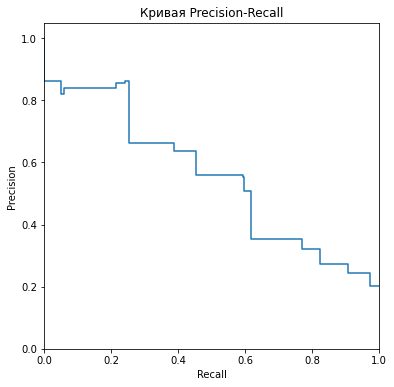

In [92]:
# найдем значения вероятностей классов для валидационной выборки
probabilities_valid = model_tree.predict_proba(features_valid_tf)

precision, recall, thresholds = precision_recall_curve(target_valid_tf, probabilities_valid[:, 1])

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show()

### 8.6. Построим ROC-кривую для модели "Дерево решений"

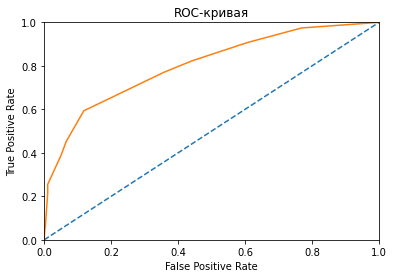

In [93]:
# найдем значения вероятностей классов для валидационной выборки
probabilities_valid = model_tree.predict_proba(features_valid_tf)

# выберем вероятности положительного класса ("1")
probabilities_one_valid = probabilities_valid[:, 1]

# передаем на вход значения целевого признака и вероятности положительного класса
fpr, tpr, thresholds = roc_curve(target_valid_tf, probabilities_one_valid)

# строим график
plt.figure()

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(fpr, tpr)
# функции plt.xlim() и plt.ylim(), чтобы установить границы осей от 0 до 1
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# подпишем оси "False Positive Rate" и "True Positive Rate"
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# заголовок "ROC-кривая"
plt.title('ROC-кривая')
plt.show()

### 8.7. Рассчитаем AUC-ROC для модели "Дерево решений"

In [94]:
auc_roc = roc_auc_score(target_valid_tf, probabilities_one_valid)
print('AUC модели DecisionTree: ', auc_roc)

AUC модели DecisionTree:  0.8015260148886032


### Выводы

* F1-score модели DecisionTree: 0.57 - не достигнут целевой показатель
* AUC модели DecisionTree: 0.80 - модель с высокой вероятностью сможет различить положительные и отрицательные значения класса

## 9. Исследуем модель "Случайный лес"

In [95]:
# создадим модель и обучим модель
model_forest = RandomForestClassifier(random_state=12345)
model_forest.fit(features_train_tf, target_train_tf)

# получим предсказание на валидационной выборке
predicted_valid_tf = model_forest.predict(features_valid_tf)

# посчитаем значение accuracy на валидационной выборке и выведем его
print('Accuracy модели RandomForest: ', accuracy_score(target_valid_tf, predicted_valid_tf), '\n', sep='')

# посчитаем значение F1-score на валидационной выборке и выведем его
print('F1-score модели RandomForest: ', f1_score(target_valid_tf, predicted_valid_tf), '\n', sep='')

Accuracy модели RandomForest: 0.8566233766233766

F1-score модели RandomForest: 0.5576923076923077



### 9.1. Подберем лучшие гиперпараметры

In [96]:
best_forest_model = None
best_result = 0
# цикл обучения модели с разным количеством деревьев от 1 до 150 и глубиной от 1 до 50

for dept in tqdm(range(1, 51, 1)):
    for est in range(1, 151, 1):
        model_forest = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=dept) # создадим модель с заданным количеством деревьев
        
        model_forest.fit(features_train_tf, target_train_tf)                                        # обучим модель используя тренировочную выборку
        
        predicted_valid_tf = model_forest.predict(features_valid_tf)
        result = f1_score(target_valid_tf, predicted_valid_tf)                      # качество модели на валидационной выборке
        
        if result > best_result:                                                    # сравним результат 
            best_forest_model = model_forest                                        # сохраним наилучшую модель
            best_result = result                                                    # сохраним наилучшее значение метрики accuracy на валидационных данных

print("F1 наилучшей модели на валидационной выборке:", f'{best_result:.4f}')
best_forest_model

100%|██████████| 50/50 [44:55<00:00, 53.92s/it]

F1 наилучшей модели на валидационной выборке: 0.5728


RandomForestClassifier(max_depth=13, n_estimators=55, random_state=12345)

#### Выводы

* Accuracy и F1-score модели RandomForest с параметрами по умолчанию лучше аналогичных показателей моделей "Логистическая регрессия" и "Решающее дерево"
* Нам известно, что целевой признак не сбалансирован, поэтому измерим порог классификации
* Улучшим модель RandomForest обучив её на выборках обработанных техниками upsampling и downsampling
* Подберем лучшие гиперпараметры для модели 

### 9.2. Измерим порог классификации

In [97]:
# игнорируем предупреждение
warnings.filterwarnings('ignore')

# найдем значения вероятностей классов для валидационной выборки
probabilities_valid = model_forest.predict_proba(features_valid_tf)
probabilities_one_valid = probabilities_valid[:, 1]

best_threshold = 0
best_result = 0

for threshold in np.arange(0, 0.95, 0.05):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid_tf, predicted_valid)
    recall = recall_score(target_valid_tf, predicted_valid)
    result = f1_score(target_valid_tf, predicted_valid)

    if result > best_result:
        best_threshold = threshold
        best_result = result
    
    print('Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f} | F1-мера = {:.3f}'.format(
             threshold, precision, recall, result))
print()
print('F1-мера лучшей модели = ', f'{best_result:.3f}','\n', sep='')
print('Порог классификации =', best_threshold)

Порог = 0.00 | Точность = 0.208, Полнота = 1.000 | F1-мера = 0.344
Порог = 0.05 | Точность = 0.272, Полнота = 0.956 | F1-мера = 0.423
Порог = 0.10 | Точность = 0.337, Полнота = 0.905 | F1-мера = 0.491
Порог = 0.15 | Точность = 0.380, Полнота = 0.830 | F1-мера = 0.521
Порог = 0.20 | Точность = 0.450, Полнота = 0.761 | F1-мера = 0.565
Порог = 0.25 | Точность = 0.500, Полнота = 0.697 | F1-мера = 0.582
Порог = 0.30 | Точность = 0.551, Полнота = 0.638 | F1-мера = 0.591
Порог = 0.35 | Точность = 0.576, Полнота = 0.573 | F1-мера = 0.575
Порог = 0.40 | Точность = 0.650, Полнота = 0.535 | F1-мера = 0.587
Порог = 0.45 | Точность = 0.687, Полнота = 0.491 | F1-мера = 0.573
Порог = 0.50 | Точность = 0.740, Полнота = 0.447 | F1-мера = 0.558
Порог = 0.55 | Точность = 0.746, Полнота = 0.401 | F1-мера = 0.522
Порог = 0.60 | Точность = 0.819, Полнота = 0.360 | F1-мера = 0.500
Порог = 0.65 | Точность = 0.840, Полнота = 0.324 | F1-мера = 0.468
Порог = 0.70 | Точность = 0.900, Полнота = 0.301 | F1-мера = 0

### 9.3. Применим технику upsampling

In [98]:
# функция для увеличения и перемешивания выборок, функция вернёт признаки и целевой признак после операции upsampling  
def upsample(features, target, repeat):                               # параметры функции: признаки, целевой признак, количество повторений
    features_zeros = features_train_tf[target_train_tf == 0]          # признаки объектов с ответом «0»
    features_ones = features_train_tf[target_train_tf == 1]           # признаки объектов с ответом «1»
    target_zeros = target_train_tf[target_train_tf == 0]              # целевой признак объектов, у которых ответы только «0»
    target_ones = target_train_tf[target_train_tf == 1]               # целевой признак объектов, у которых ответы только «1»
    
    # объединим таблицы с признаками и сохраним результат в переменной features_upsampled
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    
    # то же самое для целевого признака
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    # перемешаем
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled,random_state=12345)

    return features_upsampled, target_upsampled

# вызов функции
features_upsampled, target_upsampled = upsample(features_train_tf, target_train_tf, 4)

# проверим, что получилось
print(features_upsampled.shape)
print(target_upsampled.shape)

(9282, 10)
(9282,)


In [99]:
# создадим модель и обучим модель на увеличенных данных
model_forest = RandomForestClassifier(random_state=12345)
model_forest.fit(features_upsampled, target_upsampled)

# получим предсказание на валидационной выборке
predicted_valid_tf = model_forest.predict(features_valid_tf)

# найдем значения вероятностей классов для валидационной выборки
probabilities_valid = model_forest.predict_proba(features_valid_tf)

# выберем вероятности положительного класса ("1")
probabilities_one_valid = probabilities_valid[:, 1]

# посчитаем значение AUC-ROC на валидационной выборке и выведем его
auc_roc = roc_auc_score(target_valid_tf, probabilities_one_valid)
print('AUC-ROC модели RandomForest: ', auc_roc, '\n', sep='')


# посчитаем значение F1-score на валидационной выборке и выведем его
print('F1-score модели RandomForest: ', f1_score(target_valid_tf, predicted_valid_tf), '\n', sep='')

AUC-ROC модели RandomForest: 0.8418546151992288

F1-score модели RandomForest: 0.5722460658082975



### 9.4. Подберем лучшие гиперпараметры

In [100]:
best_forest_model = None
best_result = 0
# цикл обучения модели с разным количеством деревьев и глубиной

for dept in tqdm(range(1, 21, 1)):
    for est in range(1, 101, 1):
        model_forest = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=dept)   # создадим модель с заданным количеством деревьев
        
        model_forest.fit(features_upsampled, target_upsampled)                                        # обучим модель используя увеличенную выборку
        
        predicted_valid_tf = model_forest.predict(features_valid_tf)
        result = f1_score(target_valid_tf, predicted_valid_tf)                      # качество модели на валидационной выборке
        
        if result > best_result:                                                    # сравним результат 
            best_forest_model = model_forest                                        # сохраним наилучшую модель
            best_result = result                                                    # сохраним наилучшее значение метрики accuracy на валидационных данных

print("F1 наилучшей модели на валидационной выборке:", f'{best_result:.4f}')
best_forest_model

100%|██████████| 20/20 [09:19<00:00, 28.00s/it]

F1 наилучшей модели на валидационной выборке: 0.6097


RandomForestClassifier(max_depth=10, n_estimators=30, random_state=12345)

### 9.5. Применим технику downsampling

In [101]:
# функция для уменьшения и перемешивания
def downsample(features, target, fraction):                            # параметры функции: признаки, целевой признак, количество повторений    
    features_zeros = features_train_tf[target_train_tf == 0]           # признаки объектов с ответом «0»
    features_ones = features_train_tf[target_train_tf == 1]            # признаки объектов с ответом «1»
    target_zeros = target_train_tf[target_train_tf == 0]               # целевой признак объектов, у которых ответы только «0»
    target_ones = target_train_tf[target_train_tf == 1]                # целевой признак объектов, у которых ответы только «1»
    
    # объединим таблицы с признаками и сохраним результат в переменной 
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    
    # то же самое для целевого признака
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    # перемешиваем данные
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled,random_state=12345)
    
    return features_downsampled, target_downsampled

# вызов функции
features_downsampled, target_downsampled = downsample(features_train_tf, target_train_tf, 0.25)

# проверим, что получилось
print(features_downsampled.shape)
print(target_downsampled.shape)

(2321, 10)
(2321,)


In [102]:
# создадим модель и обучим модель на уменьшенных данных
model_forest = RandomForestClassifier(random_state=12345)
model_forest.fit(features_downsampled, target_downsampled)

# получим предсказание на валидационной выборке
predicted_valid_tf = model_forest.predict(features_valid_tf)

# найдем значения вероятностей классов для валидационной выборки
probabilities_valid = model_forest.predict_proba(features_valid_tf)

# выберем вероятности положительного класса ("1")
probabilities_one_valid = probabilities_valid[:, 1]

# посчитаем значение AUC-ROC на валидационной выборке и выведем его
auc_roc = roc_auc_score(target_valid_tf, probabilities_one_valid)
print('AUC-ROC модели RandomForest: ', auc_roc, '\n', sep='')

# посчитаем значение F1-score на валидационной выборке и выведем его
print('F1-score модели RandomForest: ', f1_score(target_valid_tf, predicted_valid_tf), '\n', sep='')

AUC-ROC модели RandomForest: 0.8482913921915166

F1-score модели RandomForest: 0.5777777777777778



### 9.6. Подберем лучшие параметры для модели

In [103]:
%%time
# определяем параметры для перебора
parametrs = {'n_estimators': range (1, 101, 1),
            'max_depth': range (1, 21, 1)
            }

# запускаем обучение
grid = GridSearchCV(model_forest, parametrs, scoring='f1', cv=5)
grid.fit(features_downsampled, target_downsampled)

# выводим результат
print(grid.best_params_)

# сигнал об окончании расчетов в ячейке
winsound.PlaySound("SystemExit", winsound.SND_ALIAS) 

{'max_depth': 9, 'n_estimators': 95}
CPU times: total: 15min 34s
Wall time: 15min 41s


#### Обучим модель с лучшим параметроми и оценим результат

In [109]:
# создадим модель и обучим модель
model_forest = RandomForestClassifier(random_state=12345, max_depth = 9, n_estimators = 95)
model_forest.fit(features_downsampled, target_downsampled)

# найдем значения вероятностей классов для валидационной выборки
probabilities_valid = model_forest.predict_proba(features_valid_tf)

# выберем вероятности положительного класса ("1")
probabilities_one_valid = probabilities_valid[:, 1]

# посчитаем значение AUC-ROC на валидационной выборке и выведем его
auc_roc = roc_auc_score(target_valid_tf, probabilities_one_valid)
print('AUC-ROC модели RandomForest: ', auc_roc, '\n', sep='')

# получим предсказание на валидационной выборке
predicted_valid_tf = model_forest.predict(features_valid_tf)

# посчитаем значение F1-score на валидационной выборке и выведем его
print('F1-score модели RandomForest: ', f1_score(target_valid_tf, predicted_valid_tf), '\n', sep='')

AUC-ROC модели RandomForest: 0.845606054520137

F1-score модели RandomForest: 0.579476861167002



### Выводы

#### Лучшая модель "Случайный лес" с параметрами (random_state=12345, max_depth=10, n_estimators=30) на увеличенной выборке

In [111]:
# создадим модель и обучим модель
model_forest = RandomForestClassifier(random_state=12345, max_depth=10, n_estimators=30)   
model_forest.fit(features_upsampled, target_upsampled)

# получим предсказание на валидационной выборке
predicted_valid_tf = model_forest.predict(features_valid_tf)

# посчитаем значение F1-score на валидационной выборке и выведем его
print('F1-score модели RandomForest: ', f1_score(target_valid_tf, predicted_valid_tf), '\n', sep='')

F1-score модели RandomForest: 0.6097271648873072



### 9.7. Построим PR-кривую для лучшей модели "Случайный лес"

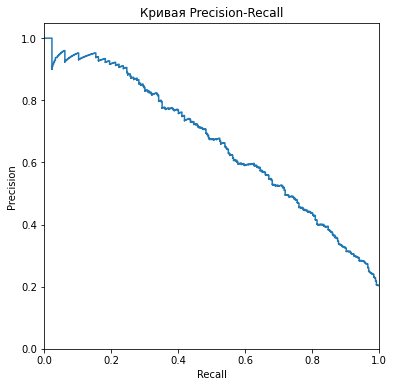

In [112]:
# найдем значения вероятностей классов для валидационной выборки
probabilities_valid = model_forest.predict_proba(features_valid_tf)

precision, recall, thresholds = precision_recall_curve(target_valid_tf, probabilities_valid[:, 1])

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show()

### 9.8. Построим ROC-кривую для модели "Случайный лес"

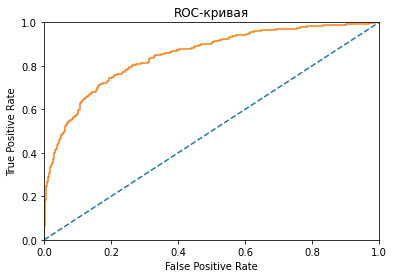

In [113]:
# найдем значения вероятностей классов для валидационной выборки
probabilities_valid = model_forest.predict_proba(features_valid_tf)

# выберем вероятности положительного класса ("1")
probabilities_one_valid = probabilities_valid[:, 1]

# передаем на вход значения целевого признака и вероятности положительного класса
fpr, tpr, thresholds = roc_curve(target_valid_tf, probabilities_one_valid)

# строим график
plt.figure()

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(fpr, tpr)
# функции plt.xlim() и plt.ylim(), чтобы установить границы осей от 0 до 1
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# подпишем оси "False Positive Rate" и "True Positive Rate"
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# заголовок "ROC-кривая"
plt.title('ROC-кривая')
plt.show()

### 9.9. Рассчитаем AUC-ROC для модели "Случайный лес"

In [114]:
auc_roc = roc_auc_score(target_valid_tf, probabilities_one_valid)
print('AUC модели RandomForest: ', auc_roc)

AUC модели RandomForest:  0.8490386675235648


### Выводы

* F1-score лучшей модели на увеличенной выборке RandomForest (max_depth=10, n_estimators=30, random_state=12345): 0.6097
* AUC модели - 0.85 и модель может с высокой вероятностью различать положительные и отрицательные значения класса

## Финальное тестирование лучшей модели

In [115]:
# создадим модель и обучим модель на тестовых данных
model_forest = RandomForestClassifier(random_state=12345, max_depth=10, n_estimators=30)
model_forest.fit(features_upsampled, target_upsampled)

# получим предсказание на тестовой выборке
predicted_test_tf = model_forest.predict(features_test_tf)

# посчитаем значение F1-score на тестовой выборке и выведем его
print('F1-score модели RandomForest: ', f1_score(target_test_tf, predicted_test_tf), '\n', sep='')

F1-score модели RandomForest: 0.5997610513739547



## Выводы 


**1. Модель "Логистическая регрессия**
- F1-score лучшей модели LogisticRegression: 0.50, целевой уровень не достигнут
- AUC модели LogisticRegression: 0.78, модель сможет различить положительные и отрицательные значения

**2. Модель "Дерево решений"**
- F1-score лучшей модели DecisionTree с настроеными гиперпараметрами: 0.57 - достигнут желаемый целевой показатель
- AUC модели DecisionTree: 0.80, значит модель с высокой вероятностью сможет различить положительные и отрицательные значения класса

**3. Модель "Случайный лес"**
- F1-score лучшей модели RandomForest с настроенными гиперпараметрами: 0.61
- AUC модели - 0.85 и модель может с высокой вероятностью различать положительные и отрицательные значения класса

**4. Финальное исследование на тестовой выборке**
- F1-score модели RandomForest на тестовой выборке: 0.5997
- Достигнут целевой показатель F1-score > 0.59
- Для дальнейшего исследования рекомендуется использовать модель "Случайный лес" с гиперпараметрами RandomForestClassifier(random_state=12345, max_depth=10, n_estimators=30)